In [ ]:
!pip install text_normalization
!pip install keras-self-attention
!pip install arabic-reshaper
!pip install python-bidi
!pip install PyArabic
!pip install camel-tools

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=6e3dc42d05e08f99462ed403c15228ade9ffec0403bec3e61aa85f32226a80fa
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 49.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Prepar

https://github.com/muhammadahmedelmahdy/Hate_speech_detection/blob/main/Final_milestone_hate_speech_detection_.ipynb

In [ ]:
import numpy as np
import pandas as pd
import text_normalization as tn
import gensim
import io

from keras.layers import Input, Embedding, GRU, GlobalMaxPool1D, Dropout, Flatten, Multiply, TimeDistributed, Reshape, Attention, Layer
from keras.layers import Dense, Activation, Concatenate, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model, model_from_json
from keras.callbacks import Callback
from keras_self_attention import SeqSelfAttention
from keras import backend as K

from keras.regularizers import L1L2
from keras.initializers import RandomNormal
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import datetime
from camel_tools.utils.normalize import normalize_unicode
from keras.utils import to_categorical, plot_model

from sklearn.metrics import (
    confusion_matrix as confmat,
    classification_report as creport
)
np.random.seed(42)

In [ ]:
import arabic_reshaper #This library is used for reshaping Arabic text, which is necessary for proper display of Arabic text on different devices.
from bidi.algorithm import get_display #This library is used for handling bidirectional text, which is necessary for proper display of Arabic text.
import pyarabic.araby as araby #This library is used for normalizing Arabic text, which is necessary for proper display of Arabic text.
import csv #This library is used for reading and writing CSV files.

import nltk
# from textaugment import Translate
# from textaugment import Wordnet
# from textaugment import Translate
# from textaugment import EDA
from nltk import ngrams

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_pref='/content/drive/My Drive/Deep_Learning_Milestone/aoc_id'
file_path = '{}/data/train/MultiTrain.Shuffled.csv'.format(file_pref)
v = False #v is used to control the verbosity of the output
n = True #n is used to control whether to use a natural language processing library
runs = 2 #increased the number of runs
p = 0.5 #p is used to control the probability of performing certain operations
n_value = 3
src = "ar"
to = "fr"

def preprocess_arabic_text(text):
    reshaped_text = arabic_reshaper.reshape(text) # reshaping text
    bidi_text = get_display(reshaped_text) # handling bidirectional text
    return bidi_text

augmented_rows = []
with open(file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        text = row['text']
        normalized_text = araby.strip_tashkeel(text)
        preprocessed_text = preprocess_arabic_text(normalized_text)

        # Your n-gram processing
        n_grams = ngrams(normalized_text.split(), n_value)  # n_value needs to be defined
        n_grams_text = " ".join([" ".join(ngram) for ngram in n_grams])
        reshaped_n_grams_text = preprocess_arabic_text(n_grams_text)

        # Update the row with augmented text
        row['text'] = reshaped_n_grams_text  # or whatever column you want to replace
        augmented_rows.append(row)

# Step 2: Write the modified data back to the file
with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=reader.fieldnames)
    writer.writeheader()
    writer.writerows(augmented_rows)

KeyboardInterrupt: ignored

In [ ]:
EmbeddingSize=300
vocab_size=50000
charset = 'ا ب ت ث ج ح خ د ذ ر ز س ش ص ض ع غ ف ق ك ل م و ه ي ى ط ظ ن'
other_symbols = '0123456789-,;.!:/\\@#%^*+-=()[] '
alphabet = (list(charset) + list(other_symbols) + ['\n'])

vocabsize=len(alphabet)+2
file_pref='/content/drive/My Drive/Deep_Learning_Milestone/aoc_id'

In [ ]:
# def LoadData(Corpus,ClassesDict,Arabic=False): ## loading file
#     DF=pd.read_csv(Corpus,converters={'text': str})
#     labels=[ClassesDict[x] for x in DF['label'].tolist()]
#     sentences=DF['text'].tolist()
#     if Arabic:
#        sentences=[tn.NormForWord2Vec(line) for line in sentences]
#     TrueLabels=labels
#     labels=to_categorical(np.asarray(labels), num_classes=len(ClassesDict))
#     return sentences,labels,TrueLabels
def LoadData(Corpus, ClassesDict, Arabic=False):
    DF = pd.read_csv(Corpus, converters={'text': str})
    labels = [ClassesDict[x] for x in DF['label'].tolist()]
    sentences = DF['text'].tolist()

    if Arabic:
        sentences = [normalize_unicode(line, compatibility=True) for line in sentences]
        # sentences = [tn.NormForWord2Vec(line) for line in sentences] # You can keep this if you have additional normalizations in NormForWord2Vec function

    TrueLabels = labels
    labels = to_categorical(np.asarray(labels), num_classes=len(ClassesDict))

    return sentences, labels, TrueLabels
def tokenizeData(X_train,X_valid,vocab_size,X_test=None): ## tokenization
    'tokenize data'
    #init tokenizer
    tokenizer= Tokenizer(num_words=vocab_size, filters='\t\n',split=' ',char_level=False)
    #use tokenizer to split vocab and index them
    tokenizer.fit_on_texts(X_train)
    ##txt to seq
    X_train= tokenizer.texts_to_sequences(X_train)
    X_valid = tokenizer.texts_to_sequences(X_valid)
    if X_test != None:
       X_test=tokenizer.texts_to_sequences(X_test)
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    return X_train,X_valid,X_test,reverse_word_map

def paddingSequence(X_train,X_valid,maxLen,X_test=None): ## Sequence Padding
    'make sure that a sequence is satisfied max_length condition'
    #######equalize list of seq
    X_train= pad_sequences(X_train, maxLen, padding='post', truncating='post')
    X_valid= pad_sequences(X_valid, maxLen, padding='post', truncating='post')
    if X_test != None:
       X_test= pad_sequences(X_test, maxLen, padding='post',truncating='post')
    return X_train,X_valid,X_test

def read_labels(categorical=False):
    count=0
    classes={}
    for line in open('{}/conf/label_list'.format(file_pref)):
        if line.strip('\n') not in classes:
            classes[line.strip('\n')] = count
            count += 1
    return classes
#######################

## Defining External Embedding Gensim functions

def GetEmbeddingWeights(embedding_dim,n_symbols,wordmap,vecDic):
    embedding_weights = np.zeros((n_symbols, embedding_dim))
    for index,word  in wordmap.items():
        if word in vecDic:
           embedding_weights[index, :] = vecDic[word]
        else:
           ## if doesn't exist initialize embedding vector from a random distribution
           embedding_weights[index, :] = np.random.randn(embedding_dim)
    return embedding_weights

def GetVecDicFromGensim(GensimFile):
    Model=gensim.models.Word2Vec.load(GensimFile)
    return Model.wv

def load_fasttext(FastTextFile):
    fin = io.open(FastTextFile, 'r', encoding='utf-8', newline='\n', errors='ignore')
    #n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array([list(map(float, tokens[1:]))])
    return data

#####################################
def get_char2idx(x):
    st=''
    for line in x:
        st+=line
    charset=set(st)
    vocabsize=len(charset)
    char2idx= dict(zip(list(charset),range(1,len(charset)+1)))
    return char2idx,vocabsize
#####################################
def encode_all_data2chars(x,char2idx):
    X_return=[]
    for line in x:
        idxs= [char2idx.get(c,1) for c in line]
        X_return.append(idxs)
    return X_return
#####################################
def encode_data2char(x):
    char2idx = dict(zip(list(alphabet), range(2, len(alphabet) + 2)))
    print(len(char2idx))
    X=[]
    for line in x:
        indices = [char2idx.get(c, 1) for c in line]
        X.append(indices)
    return X
#####################################
def get_word_map_num_symbols(corpus):
    X_train,Y_train,Y_Train_true=LoadData(corpus,ClassesDict=get_classes())
    X_test,Y_test,Y_test_true=LoadData(corpus,ClassesDict=get_classes())
    print ('---- Tokenizing Training and Testing Data ------')
    X_train,X_test,dummy,wordmap=tokenizeData(X_train,X_test,vocab_size=get_vocab_size())
    n_symbols=len(wordmap)+1
    return n_symbols,wordmap
#####################################
def set_corpus(Corpus):
    corpus=Corpus
    return corpus
#####################################
def get_classes():
    return Classes
def get_corpus():
    return Corpus
def get_testset():
    return Testset
def get_vocab_size():
    return vocab_size
def get_n_symbold():
    return
###########
Classes=read_labels()
#############################################
Corpus='{}/data/train/MultiTrain.Shuffled.Augmented.csv'.format(file_pref)
Testset='{}/data/dev/MultiDev.csv'.format(file_pref)

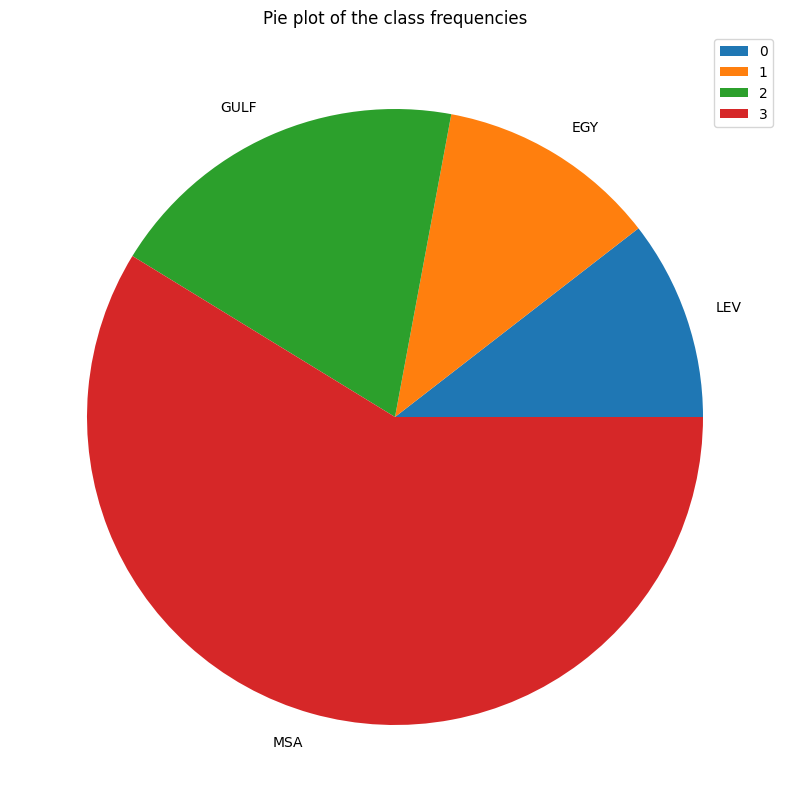

In [ ]:
LABELS = ('LEV' , 'EGY' , 'GULF' , 'MSA')
X_train,Y_train,Y_Train_true=LoadData(Corpus,ClassesDict=get_classes())
X_test,Y_test,Y_test_true=LoadData(Corpus,ClassesDict=get_classes())
tmp = np.concatenate((Y_Train_true, Y_test_true))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure('Target Pie', figsize=(10, 10))
plt.title('Pie plot of the class frequencies')
plt.pie(counts, labels=LABELS)
plt.legend(unique)
plt.savefig('{}/img/CNN_stats_classes.png'.format(file_pref))
plt.show()

### Callback function to stop the training after a certain accuracy

In [ ]:
class Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        if acc is not None:
            if acc >= 0.85:
                self.model.stop_training = True

In [ ]:
#Defining attention layers
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
      return super(attention,self).get_config()


In [ ]:
class General():
    def __init__(self,):
       self.model=None
       # Training parameters
       self.batch_size = None
       self.num_epochs = None
       # Prepossessing parameters
       self.sequence_length = None
       self.vocab_size = None  ## changed to fit data size
       self.LoadedModel=None
       self.Model=None
       self.ExternalEmbeddingModel = None
       self.EmbeddingType=None

    def set_etxrernal_embedding(self,ModelFile,ModelType):
        self.ExternalEmbeddingModel=ModelFile
        self.EmbeddingType=ModelType

    def set_training_paramters(self,batch_size,num_epochs):
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    def set_processing_parameters(self,sequence_length,vocab_size):
        self.sequence_length=sequence_length
        self.vocab_size=vocab_size

    def train_model(self,Model,X_train,Y_train,X_valid,Y_valid):
        history = Model.fit(X_train, Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=self.num_epochs,
                            batch_size=self.batch_size,
                            callbacks=[Callback()])
        return history

    def Evaluate_model(self,Model,X_test,Y_test):
        score=Model.evaluate(X_test,Y_test,verbose=0)
        return score

    def save_model(self,ModelFileName,Model):
        print('Saving model in directory:')
        JsonModel = Model.to_json()
        with open('{}/models/'.format(file_pref) + ModelFileName + '.json', 'w') as json_file:
            json_file.write(JsonModel)
        Model.save_weights('models/' + ModelFileName + '.h')
        print('model saved in directory')

    def Load_model(self,ModelFileName):
        print('Loading Model from directory!')

        JsonFile = open(ModelFileName+'.json','r')

        # Load Json file
        LoadedModel = model_from_json(JsonFile)

        # Load weights
        LoadedModel.load_weights(ModelFileName+'.h5')
        LoadedModel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        return LoadedModel

    #def Return_preds(self,Model,X_test):

In [ ]:
class cnn_kim(General): ##inherits General
    '''
    CNNfor text classification based on kim 2014
    works for both static and non-static
    different is that network is initialized with RandomNormal distribution
    of small standard deviation
    '''
    def __init__(self,cnn_rand=True,STATIC=False,ExternalEmbeddingModel=None,EmbeddingType=None,n_symbols=None,wordmap=None):
        # Model hyperparameters
        self.embedding_dim=300##
        self.filter_sizes = (3, 8)
        self.num_filters = 10
        self.hidden_dims=200 ## changed (100)
        self.dropout_prob=(0.1,0.1) ## changed (0.5, 0.8)
        self.loss='categorical_crossentropy'
        self.optimizer= 'rmsprop'
        self.l1_reg=2
        self.l2_reg=0.5 ##according to kim14
        self.std=0.05 ## standard deviation
        # Training Parameters
        self.set_training_paramters(batch_size=32,num_epochs=40) ## epochs was 10
        self.set_processing_parameters(sequence_length=30,vocab_size=vocabsize) ## changed to fit short text

        # Defining Model Layers
        if cnn_rand:
            ##Embedding Layer Randomly initialized
            embedding_layer=Embedding(output_dim=self.embedding_dim, input_dim=self.vocab_size)
            Classes = read_labels()
            n_classes = len(Classes)

        else:
            ## Use pretrained model
            #n_symbols, wordmap = get_word_map_num_symbols()
            self.set_etxrernal_embedding(ExternalEmbeddingModel,ModelType=EmbeddingType)
            if self.EmbeddingType == 'skipgram' or self.EmbeddingType == 'CBOW':
               vecDic = GetVecDicFromGensim(self.ExternalEmbeddingModel)
            elif self.EmbeddingType == 'fastText':
               vecDic = load_fasttext(self.ExternalEmbeddingModel)
            Classes = read_labels()
            n_classes = len(Classes)
            ## Define Embedding Layer
            embedding_weights = GetEmbeddingWeights(embedding_dim=300, n_symbols=n_symbols, wordmap=wordmap,
                                                       vecDic=vecDic)
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=n_symbols, trainable=STATIC)
            embedding_layer.build((None,))  # if you don't do this, the next step won't work
            embedding_layer.set_weights([embedding_weights])

        Sequence_in = Input(shape=(self.sequence_length,), dtype='int32')
        embedding_seq = embedding_layer(Sequence_in)
        x = Dropout(self.dropout_prob[0])(embedding_seq)
        ## define Core Convultional Layers
        conv_blocks = []
        for sz in self.filter_sizes:
            conv = Conv1D(filters=self.num_filters,
                                 kernel_size=sz,
                                 padding='valid',
                                 activation='relu',
                                 strides=1)(x)
            conv =  MaxPooling1D(pool_size=2)(conv)
            conv = attention()(conv)
            conv = Flatten()(conv)
            conv_blocks.append(conv)
            #conv_blocks.append(attention())

        x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
        # print("Shape before SeqSelfAttention:", K.int_shape(x))
        # x = Reshape((10, 25))(x)
        # x = SeqSelfAttention(attention_activation='sigmoid')(x)
        # # x = GlobalMaxPooling1D()(x)
        # # # After attention, flatten to connect to a dense layer
        x = Flatten()(x)
        #  # Apply Attention
        # query_value_attention_seq = Attention()([x, x])
        # query_value_attention = GlobalAveragePooling1D()(query_value_attention_seq)

        # # Combine with original CNN output
        # combined = Concatenate()([GlobalMaxPooling1D()(x), query_value_attention])

        # Final Dense Layers
        x = Dropout(self.dropout_prob[1])(x)
        #x = Dropout(self.dropout_prob[1])(x)
        x = Dense(self.hidden_dims, activation='relu',kernel_initializer=RandomNormal(stddev=self.std),
                         kernel_regularizer=L1L2(l1=self.l1_reg,l2=self.l2_reg))(x)
        preds = Dense(n_classes, activation='sigmoid')(x)
        ## return graph model
        model = Model(Sequence_in, preds)
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        self.model=model
        # x = Reshape((1, self.hidden_dims))(x)
        # x = SeqSelfAttention(attention_activation='sigmoid')(x)

In [ ]:
class base_cnn_kim(General): ##inherits General
    '''
    CNNfor text classification based on kim 2014
    works for both static and non-static
    different is that network is initialized with RandomNormal distribution
    of small standard deviation
    '''
    def __init__(self,cnn_rand=True,STATIC=False,ExternalEmbeddingModel=None,EmbeddingType=None,n_symbols=None,wordmap=None):
        # Model hyperparameters
        self.embedding_dim=300##
        self.filter_sizes = (3, 8)
        self.num_filters = 10
        self.hidden_dims=100
        self.dropout_prob=(0.5,0.8)
        self.loss='categorical_crossentropy'
        self.optimizer= 'rmsprop'
        self.l1_reg=0
        self.l2_reg=3 ##according to kim14
        self.std=0.05 ## standard deviation
        # Training Parameters
        self.set_training_paramters(batch_size=64,num_epochs=10)
        self.set_processing_parameters(sequence_length=30,vocab_size=vocabsize) ## changed to fit short text

        # Defining Model Layers
        if cnn_rand:
            ##Embedding Layer Randomly initialized
            embedding_layer=Embedding(output_dim=self.embedding_dim, input_dim=self.vocab_size)
            Classes = read_labels()
            n_classes = len(Classes)

        else:
            ## Use pretrained model
            #n_symbols, wordmap = get_word_map_num_symbols()
            self.set_etxrernal_embedding(ExternalEmbeddingModel,ModelType=EmbeddingType)
            if self.EmbeddingType == "skipgram" or self.EmbeddingType == "CBOW":
               vecDic = GetVecDicFromGensim(self.ExternalEmbeddingModel)
            elif self.EmbeddingType == "fastText":
               vecDic = load_fasttext(self.ExternalEmbeddingModel)
            Classes = read_labels()
            n_classes = len(Classes)
            ## Define Embedding Layer
            embedding_weights = GetEmbeddingWeights(embedding_dim=300, n_symbols=n_symbols, wordmap=wordmap,
                                                       vecDic=vecDic)
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=n_symbols, trainable=STATIC)
            embedding_layer.build((None,))  # if you don't do this, the next step won't work
            embedding_layer.set_weights([embedding_weights])

        Sequence_in = Input(shape=(self.sequence_length,), dtype='int32')
        embedding_seq = embedding_layer(Sequence_in)
        x = Dropout(self.dropout_prob[0])(embedding_seq)
        ## define Core Convultional Layers
        conv_blocks = []
        for sz in self.filter_sizes:
            conv = Conv1D(filters=self.num_filters,
                                 kernel_size=sz,
                                 padding="valid",
                                 activation="relu",
                                 strides=1)(x)
            conv =  MaxPooling1D(pool_size=2)(conv)
            conv = Flatten()(conv)
            conv_blocks.append(conv)

        x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
        x = Dropout(self.dropout_prob[1])(x)
        x = Dense(self.hidden_dims, activation="relu",kernel_initializer=RandomNormal(stddev=self.std),
                         kernel_regularizer=L1L2(l1=self.l1_reg,l2=self.l2_reg))(x)
        preds = Dense(n_classes, activation='softmax')(x)
        ## return graph model
        model = Model(Sequence_in, preds)
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        self.model=model


In [ ]:
class base_BasicLSTM(General): ## inherits General
    '''
    LSTM Our implementation
    '''
    def __init__(self,lstm_rand=True,STATIC=False,ExternalEmbeddingModel=None,EmbeddingType=None,n_symbols=None,wordmap=None):
        self.embedding_dim = 300
        self.hidden_dims = 100
        self.dropout_prob = (0.5, 0.8)
        self.loss = 'categorical_crossentropy'
        self.optimizer = 'rmsprop'
        self.l1_reg = 0
        self.l2_reg = 3  ##according to kim14
        self.std = 0.05  ## standard deviation
        # Training Parameters
        self.set_training_paramters(batch_size=64, num_epochs=10)
        self.set_processing_parameters(sequence_length=30, vocab_size=50000)  ## changed to fit short text
        # Defining Model Layers        if clstm_rand:
        ##Embedding Layer Randomly initialized
        if lstm_rand:
            ##Embedding Layer Randomly initialized
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=self.vocab_size)
            Classes = read_labels()
            n_classes = len(Classes)

        else:
            ## Use pretrained model
            # n_symbols, wordmap = get_word_map_num_symbols()
            self.set_etxrernal_embedding(ExternalEmbeddingModel, ModelType=EmbeddingType)
            if self.EmbeddingType == "skipgram" or self.EmbeddingType == "CBOW":
                vecDic = GetVecDicFromGensim(self.ExternalEmbeddingModel)
            elif self.EmbeddingType == "fastText":
                vecDic = load_fasttext(self.ExternalEmbeddingModel)
            Classes = read_labels()
            n_classes = len(Classes)
            ## Define Embedding Layer
            embedding_weights = GetEmbeddingWeights(embedding_dim=300, n_symbols=n_symbols, wordmap=wordmap,
                                                       vecDic=vecDic)
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=n_symbols, trainable=STATIC)
            embedding_layer.build((None,))  # if you don't do this, the next step won't work
            embedding_layer.set_weights([embedding_weights])

        Sequence_in = Input(shape=(self.sequence_length,), dtype='int32')
        embedding_seq = embedding_layer(Sequence_in)
        x = Dropout(self.dropout_prob[0])(embedding_seq)
        x = LSTM(self.hidden_dims, kernel_initializer=RandomNormal(stddev=self.std),
                 kernel_regularizer=L1L2(l1=self.l1_reg, l2=self.l2_reg), return_sequences=False)(x)
        preds = Dense(n_classes, activation='softmax')(x)
        ## return graph model
        model = Model(Sequence_in, preds)
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        self.model = model

##

In [ ]:
class BasicLSTM(General): ## inherits General
    '''
    LSTM Our implementation
    '''
    def __init__(self,lstm_rand=True,STATIC=False,ExternalEmbeddingModel=None,EmbeddingType=None,n_symbols=None,wordmap=None):
        self.embedding_dim = 300
        self.hidden_dims = 100
        self.dropout_prob = (0.5, 0.8)
        self.loss = 'categorical_crossentropy'
        self.optimizer = 'rmsprop'
        self.l1_reg = 0
        self.l2_reg = 3  ##according to kim14
        self.std = 0.05  ## standard deviation
        # Training Parameters
        self.set_training_paramters(batch_size=32, num_epochs=40)
        self.set_processing_parameters(sequence_length=30, vocab_size=50000)  ## changed to fit short text
        # Defining Model Layers        if clstm_rand:
        ##Embedding Layer Randomly initialized
        if lstm_rand:
            ##Embedding Layer Randomly initialized
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=self.vocab_size)
            Classes = read_labels()
            n_classes = len(Classes)

        else:
            ## Use pretrained model
            # n_symbols, wordmap = get_word_map_num_symbols()
            self.set_etxrernal_embedding(ExternalEmbeddingModel, ModelType=EmbeddingType)
            if self.EmbeddingType == 'skipgram' or self.EmbeddingType == 'CBOW':
                vecDic = GetVecDicFromGensim(self.ExternalEmbeddingModel)
            elif self.EmbeddingType == 'fastText':
                vecDic = load_fasttext(self.ExternalEmbeddingModel)
            Classes = read_labels()
            n_classes = len(Classes)
            ## Define Embedding Layer
            embedding_weights = GetEmbeddingWeights(embedding_dim=300, n_symbols=n_symbols, wordmap=wordmap,
                                                       vecDic=vecDic)
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=n_symbols, trainable=STATIC)
            embedding_layer.build((None,))  # if you don't do this, the next step won't work
            embedding_layer.set_weights([embedding_weights])

        Sequence_in = Input(shape=(self.sequence_length,), dtype='int32')
        embedding_seq = embedding_layer(Sequence_in)
        x = Dropout(self.dropout_prob[0])(embedding_seq)
        #x = SeqSelfAttention(attention_activation='sigmoid')(x)
        x = LSTM(self.hidden_dims, kernel_initializer=RandomNormal(stddev=self.std),
                 kernel_regularizer=L1L2(l1=self.l1_reg, l2=self.l2_reg), return_sequences=False)(x)
        x = attention=(x)
        preds = Dense(n_classes, activation='softmax')(x)
        ## return graph model
        model = Model(Sequence_in, preds)
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        self.model = model

In [ ]:
class BasicBiLSTM(General): ## inherits General
    '''
    BiLSTM Our implementation
    '''
    def __init__(self,bilstm_rand=True,STATIC=False,ExternalEmbeddingModel=None,EmbeddingType=None,n_symbols=None,wordmap=None):
        self.embedding_dim = 300
        self.hidden_dims = 100
        self.dropout_prob = (0.5, 0.8)
        self.loss = 'categorical_crossentropy'
        self.optimizer = 'rmsprop'
        self.l1_reg = 0
        self.l2_reg = 3  ##according to kim14
        self.std = 0.05  ## standard deviation
        # Training Parameters
        self.set_training_paramters(batch_size=32, num_epochs=50)
        self.set_processing_parameters(sequence_length=30, vocab_size=50000)  ## changed to fit short text
        # Defining Model Layers        if clstm_rand:
        ##Embedding Layer Randomly initialized
        if bilstm_rand:
            ##Embedding Layer Randomly initialized
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=self.vocab_size)
            Classes = read_labels()
            n_classes = len(Classes)

        else:
            ## Use pretrained model
            # n_symbols, wordmap = get_word_map_num_symbols()
            self.set_etxrernal_embedding(ExternalEmbeddingModel, ModelType=EmbeddingType)
            if self.EmbeddingType == 'skipgram' or self.EmbeddingType == 'CBOW':
                vecDic = GetVecDicFromGensim(self.ExternalEmbeddingModel)
            elif self.EmbeddingType == 'fastText':
                vecDic = load_fasttext(self.ExternalEmbeddingModel)
            Classes = read_labels()
            n_classes = len(Classes)
            ## Define Embedding Layer
            embedding_weights = GetEmbeddingWeights(embedding_dim=300, n_symbols=n_symbols, wordmap=wordmap,
                                                       vecDic=vecDic)
            embedding_layer = Embedding(output_dim=self.embedding_dim, input_dim=n_symbols, trainable=STATIC)
            embedding_layer.build((None,))  # if you don't do this, the next step won't work
            embedding_layer.set_weights([embedding_weights])

        Sequence_in = Input(shape=(self.sequence_length,), dtype='int32')
        embedding_seq = embedding_layer(Sequence_in)
        x = Dropout(self.dropout_prob[0])(embedding_seq)
        x = SeqSelfAttention(attention_activation='sigmoid')(x)
        x = Bidirectional(LSTM(self.hidden_dims, kernel_initializer=RandomNormal(stddev=self.std),
                 kernel_regularizer=L1L2(l1=self.l1_reg, l2=self.l2_reg), return_sequences=False))(x)
        preds = Dense(n_classes, activation='softmax')(x)
        ## return graph model
        model = Model(Sequence_in, preds)
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        self.model = model

In [ ]:
Arabic=False
RAND=False
Trainable=False
model_type='cnn'
train_corpus='{}/data/train/MultiTrain.Shuffled.csv'.format(file_pref)
valid_corpus='{}/data/kickstarter/valid_data.csv'.format(file_pref)
test_corpus='{}/data/kickstarter/test_data.csv'.format(file_pref)
EMB_type='CBOW'
embedd_file='{}/EmbeddingModels/CbowModel.mdl'.format(file_pref)
ModelFile='{}_trial1'.format(model_type)

In [ ]:
print('----- Load Train and Test Data --------')
X_train, Y_train, Y_train_true = LoadData(train_corpus,ClassesDict=get_classes(),Arabic=Arabic)
X_valid, Y_valid, Y_valid_true = LoadData(valid_corpus,ClassesDict=get_classes(),Arabic=Arabic)
X_test, Y_test, Y_test_true = LoadData(test_corpus, ClassesDict=get_classes(),Arabic=Arabic)

print('---- Tokenizing Training and Testing Data ------')
X_train, X_valid, X_test, wordmap = tokenizeData(X_train, X_valid, vocab_size=get_vocab_size(),X_test=X_test)
X_train, X_valid, X_test = paddingSequence(X_train, X_valid, maxLen=30,X_test=X_test)
n_symbols, word_map = get_word_map_num_symbols(train_corpus)

----- Load Train and Test Data --------
---- Tokenizing Training and Testing Data ------
---- Tokenizing Training and Testing Data ------


In [ ]:
!pip install pydot graphviz
!pip install hiddenlayer
!pip install keras-visualizer
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
from keras_visualizer import visualizer
import visualkeras
from PIL import Image, ImageDraw

## CNN Model

In [ ]:
FW = open('CNN_scores.txt','w')
model_class = cnn_kim(cnn_rand=RAND,STATIC=Trainable,ExternalEmbeddingModel=embedd_file,EmbeddingType=EMB_type,n_symbols=n_symbols,wordmap=word_map)
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime('%Y%m%d_%H%M%S')
model_name = 'CNN_final'

NameError: ignored

In [ ]:
model_class.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 300)              5134920   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 dropout_2 (Dropout)         (None, 30, 300)              0         ['embedding_1[0][0]']         
                                                                                                  
 conv1d_2 (Conv1D)           (None, 28, 10)               9010      ['dropout_2[0][0]']     

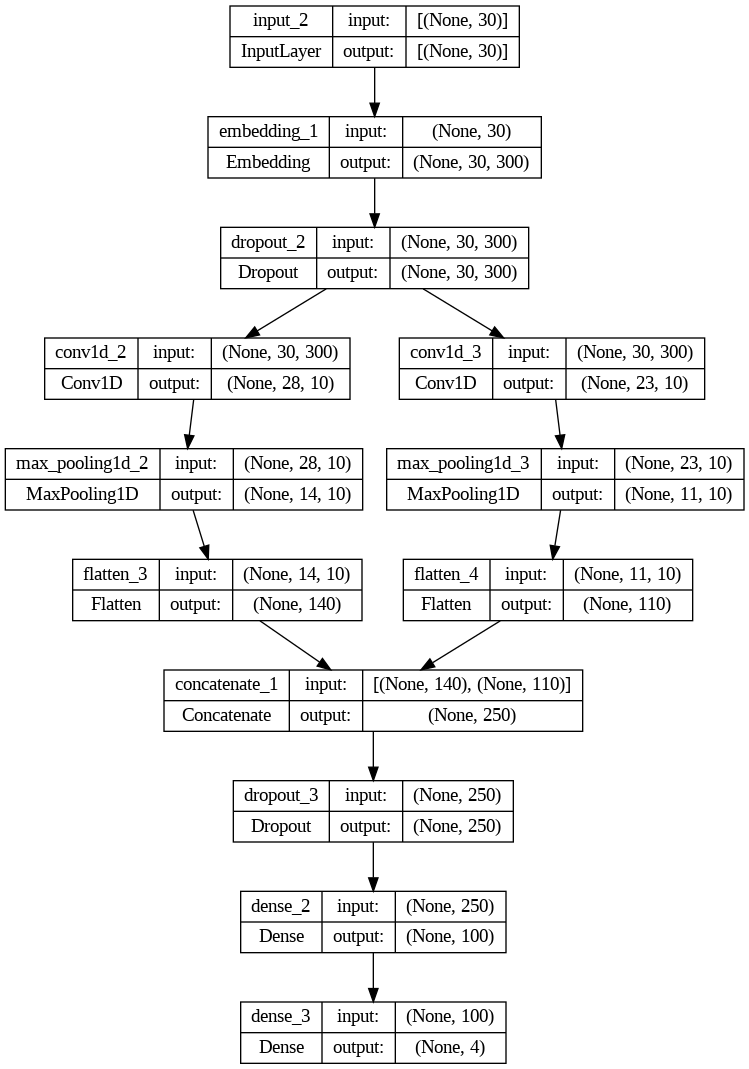

In [ ]:
plot_model(model_class.model, to_file="{}/img/CNN_model_architecture.png".format(file_pref), show_shapes=True, show_layer_names=True)

In [ ]:
history = model_class.train_model(model_class.model,X_train,Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid)
ValidScore = model_class.Evaluate_model(model_class.model,X_valid,Y_valid)
TestScore = model_class.Evaluate_model(model_class.model,X_test,Y_test)
FW.write('CNN Validation score: '+str(ValidScore)+'\n')
FW.write('CNN Test score: '+str(TestScore)+'\n')
FW.close()
model_class.save_model(ModelFile,model_class.model)
predictions_cnn = model_class.model.predict(X_test)

Epoch 1/40
2705/2705 [==============================] - 29s 6ms/step - loss: 7.9336 - accuracy: 0.6432 - val_loss: 4.8965 - val_accuracy: 0.6720
Epoch 2/40
2705/2705 [==============================] - 19s 7ms/step - loss: 4.9135 - accuracy: 0.6760 - val_loss: 4.8302 - val_accuracy: 0.6675
Epoch 3/40
2705/2705 [==============================] - 17s 6ms/step - loss: 4.8799 - accuracy: 0.6876 - val_loss: 4.9791 - val_accuracy: 0.6640
Epoch 4/40
2705/2705 [==============================] - 16s 6ms/step - loss: 4.8625 - accuracy: 0.6935 - val_loss: 5.0493 - val_accuracy: 0.6538
Epoch 5/40
2705/2705 [==============================] - 17s 6ms/step - loss: 4.8474 - accuracy: 0.6999 - val_loss: 4.9469 - val_accuracy: 0.6818
Epoch 6/40
2705/2705 [==============================] - 17s 6ms/step - loss: 4.8419 - accuracy: 0.7024 - val_loss: 4.9541 - val_accuracy: 0.6621
Epoch 7/40
2705/2705 [==============================] - 16s 6ms/step - loss: 4.8358 - accuracy: 0.7074 - val_loss: 4.8030 - val_ac

In [ ]:
np.save('model_cnn_predictions.npy', predictions_cnn)

## LSTM Model

In [ ]:
FW = open('LSTM_score.txt','w')
model_class=BasicLSTM(lstm_rand=RAND,STATIC=Trainable,ExternalEmbeddingModel=embedd_file,EmbeddingType=EMB_type,n_symbols=n_symbols,wordmap=word_map)
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime('%Y%m%d_%H%M%S')
model_name = 'LSTM_Final'

In [ ]:
model_class.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 30, 300)           51349200  
                                                                 
 dropout_4 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
Total params: 51510004 (196.50 MB)
Trainable params: 160804 (628.14 KB)
Non-trainable params: 51349200 (195.88 MB)
_________________________________________________________________


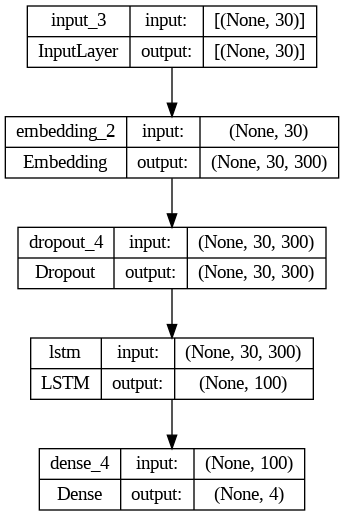

In [ ]:
plot_model(model_class.model, to_file="{}/img/Base_LSTM_model_architecture.png".format(file_pref), show_shapes=True, show_layer_names=True)

In [2]:
history = model_class.train_model(model_class.model,X_train=X_train,Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid)
ValidScore = model_class.Evaluate_model(model_class.model, X_valid, Y_valid)
TestScore = model_class.Evaluate_model(model_class.model, X_test, Y_test)
FW.write('LSTM Validation score: ' + str(ValidScore) + '\n')
FW.write('LSTM Test score: ' + str(TestScore) + '\n')
FW.close()
model_class.save_model(ModelFile, model_class.model)
predictions_lstm = model_class.model.predict(X_test)
np.save('model_lstm_predictions.npy', predictions_lstm)

NameError: ignored

## BiLSTM Model

In [ ]:
FW = open('BLSTM_score.txt', 'w')
model_class = BasicBiLSTM(bilstm_rand=RAND, STATIC=Trainable, ExternalEmbeddingModel=embedd_file,EmbeddingType=EMB_type,n_symbols=n_symbols,wordmap=word_map)
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime('%Y%m%d_%H%M%S')
model_name = 'BiLSTM_' + formatted_datetime

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
model_class.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           51349200  
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 seq_self_attention (SeqSel  (None, 30, 300)           19265     
 fAttention)                                                     
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 4)                 804   

In [ ]:
history = model_class.train_model(model_class.model, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid)
ValidScore = model_class.Evaluate_model(model_class.model, X_valid, Y_valid)
TestScore = model_class.Evaluate_model(model_class.model, X_test, Y_test)
FW.write('BiLSTM Validation score: ' + str(ValidScore) + '\n')
FW.write('BiLSTM Test score: ' + str(TestScore) + '\n')
FW.close()
model_class.save_model(ModelFile, model_class.model)

Epoch 1/20
2705/2705 [==============================] - 38s 10ms/step - loss: 16.3670 - accuracy: 0.7365 - val_loss: 0.9963 - val_accuracy: 0.7713
Epoch 2/20
2705/2705 [==============================] - 24s 9ms/step - loss: 0.9587 - accuracy: 0.7681 - val_loss: 1.2347 - val_accuracy: 0.7348
Epoch 3/20
2705/2705 [==============================] - 25s 9ms/step - loss: 0.9418 - accuracy: 0.7702 - val_loss: 0.9234 - val_accuracy: 0.7902
Epoch 4/20
2705/2705 [==============================] - 23s 9ms/step - loss: 0.9333 - accuracy: 0.7734 - val_loss: 0.9217 - val_accuracy: 0.8023
Epoch 5/20
2705/2705 [==============================] - 28s 10ms/step - loss: 0.9310 - accuracy: 0.7750 - val_loss: 1.0061 - val_accuracy: 0.8048
Epoch 6/20
2705/2705 [==============================] - 23s 9ms/step - loss: 0.9277 - accuracy: 0.7762 - val_loss: 0.9024 - val_accuracy: 0.8055
Epoch 7/20
2705/2705 [==============================] - 26s 9ms/step - loss: 0.9261 - accuracy: 0.7762 - val_loss: 0.9206 - val

In [ ]:
# Example weights
weight_cnn = 0.9  # Adjust based on performance
weight_lstm = 0.1  # Adjust based on performance


# Example loading predictions (adjust based on your file format)
cnn_predictions = np.load('model_cnn_predictions.npy')
lstm_predictions = np.load('model_lstm_predictions.npy')

ensemble_predictions = (cnn_predictions * weight_cnn) + (lstm_predictions * weight_lstm)

ensemble_class_labels = np.argmax(ensemble_predictions, axis=1)


In [ ]:
true_class_labels = np.argmax(Y_test, axis=1)  # Adjust as per your test label format
accuracy = np.mean(ensemble_class_labels == true_class_labels)
print(f'Ensemble Model Accuracy: {accuracy * 100:.2f}%')

Ensemble Model Accuracy: 81.53%


## Metrics

### Confusion Matrix

In [ ]:
y_pred = np.argmax(model_class.model.predict(X_test), axis=1)
# y_pred = np_utils.to_categorical(np.argmax(y_pred, axis=1), len(CLASSES_LIST))

cm = confmat(np.argmax(Y_test, axis=1), y_pred)

print("Confusion Matrix :\n\n {}\n".format(cm))
print(creport(np.argmax(Y_test, axis=1), y_pred))

338/338 [==============================] - 1s 3ms/step
Confusion Matrix :

 [[ 383   36  398  316]
 [ 108  693   71  380]
 [  51    8 1317  697]
 [  62   11  370 5911]]

              precision    recall  f1-score   support

           0       0.63      0.34      0.44      1133
           1       0.93      0.55      0.69      1252
           2       0.61      0.64      0.62      2073
           3       0.81      0.93      0.87      6354

    accuracy                           0.77     10812
   macro avg       0.75      0.61      0.66     10812
weighted avg       0.77      0.77      0.75     10812



### Early Stopping

In [ ]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 25
Accuracy on train : 78.3 %
Accuracy on test : 79.7 %
Loss on train : 470.1
Loss on test : 451.85


### Loss and Accuracy Plots

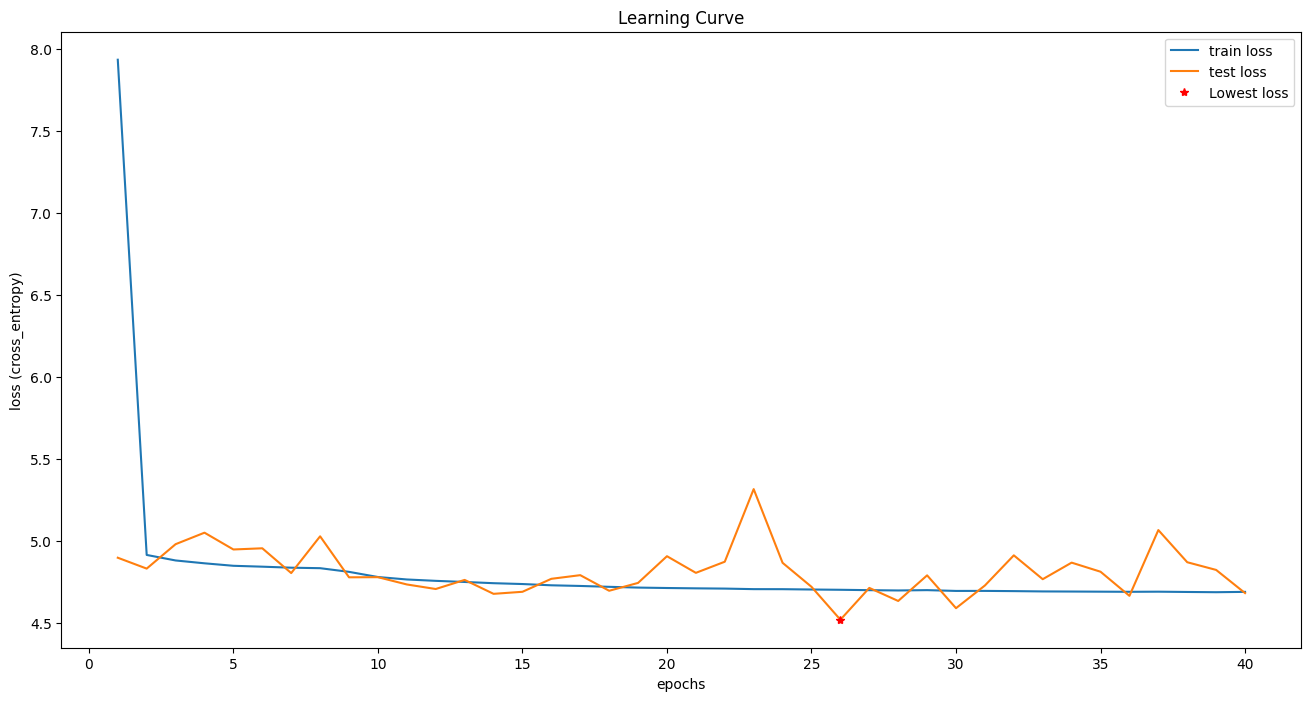

In [ ]:
plt.figure("Loss Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="test loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.savefig(f"{{}}/img/{model_name}_loss.png".format(file_pref))
plt.show();

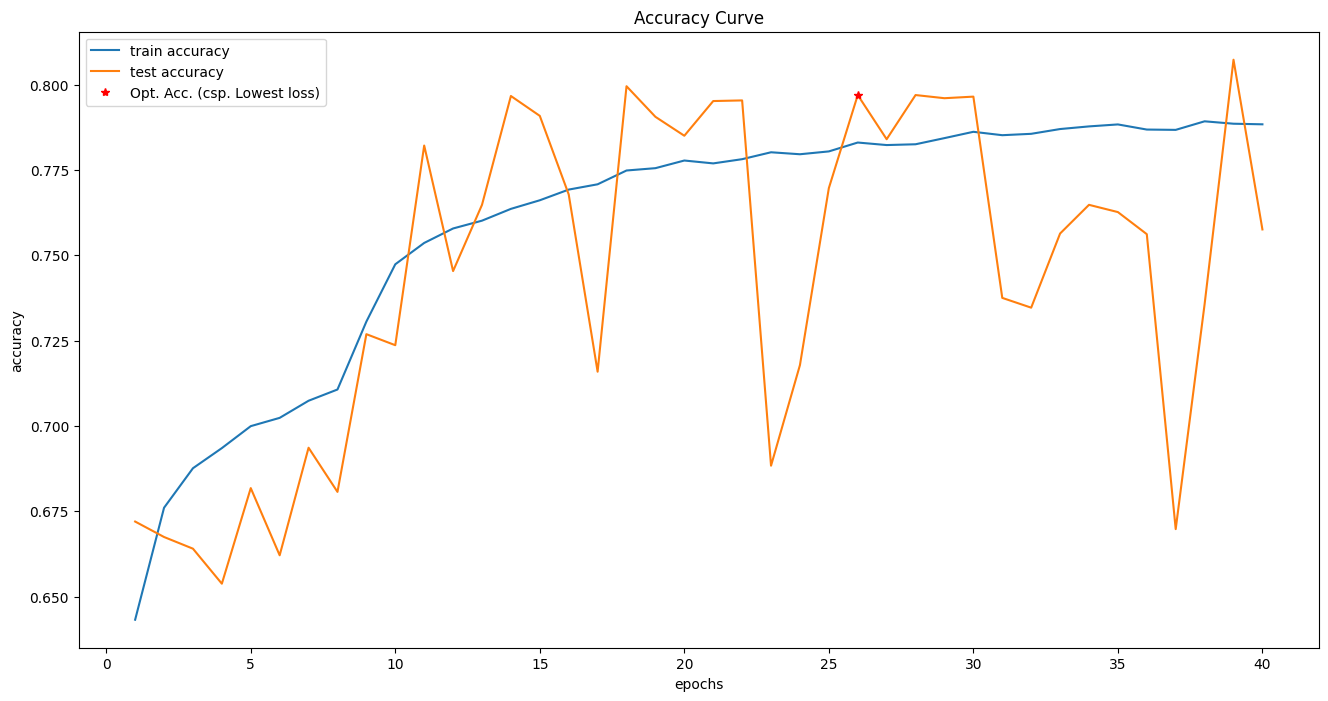

In [ ]:
plt.figure("Accuracy Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="test accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.savefig(f"{{}}/img/{model_name}_accuracy.png".format(file_pref))
plt.show()